# CMIP6 Negative values

**Following steps are included in this script:**

1. Load netCDF files
2. Remove not logic negative values
3. Save and replace netcdf files

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import importlib
import copy
import numpy as np

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [2]:
def check_positive_negative_values(ds_dict):
    """
    Check for positive and negative values in each dataset within the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.

    Returns:
    None: Prints statements indicating variables with positive and negative values and their counts.
    """
    for name, ds in ds_dict.items():
        print(f"Checking positive and negative values for model: {name}")
        for var_name in ds.data_vars:
            negative_values = ds[var_name].where(ds[var_name] < 0).count().item()
            positive_values = ds[var_name].where(ds[var_name] > 0).count().item()

            if negative_values > 0:
                print(f"- {var_name}: {negative_values}")
            else:
                print(f"- {var_name}: 0")

            if positive_values > 0:
                print(f"+ {var_name}: {positive_values}")
            else:
                print(f"+ {var_name}: 0")

            if negative_values > positive_values:
                print(f"WARNING: Variable '{var_name}' has more negative ({negative_values}) than positive ({positive_values}) values in model '{name}'.")
                
        print("\n")

In [3]:
def correct_variable_sign(ds_dict, model_name, var_name):
    """
    Correct the sign of the specified variable for a specific model.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.
    model_name (str): The name of the model to correct.
    var_name (str): The name of the variable to correct.

    Returns:
    dict: Updated dictionary with corrected sign for the specified variable.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)

    if model_name not in ds_dict_copy:
        print(f"Model '{model_name}' not found in the dataset dictionary.")
        return ds_dict_copy

    ds = ds_dict_copy[model_name]

    if var_name not in ds:
        print(f"Variable '{var_name}' not found in model '{model_name}'.")
        return ds_dict_copy

    # Count positive and negative values before correction
    positive_values_before = ds[var_name].where(ds[var_name] > 0).count().item()
    negative_values_before = ds[var_name].where(ds[var_name] < 0).count().item()

    print(f"Before correction for model '{model_name}', variable '{var_name}':")
    print(f"Positive values: {positive_values_before}")
    print(f"Negative values: {negative_values_before}")

    # Correct the sign of the variable
    ds[var_name] = -ds[var_name]

    # Count positive and negative values after correction
    positive_values_after = ds[var_name].where(ds[var_name] > 0).count().item()
    negative_values_after = ds[var_name].where(ds[var_name] < 0).count().item()

    print(f"After correction for model '{model_name}', variable '{var_name}':")
    print(f"Positive values: {positive_values_after}")
    print(f"Negative values: {negative_values_after}")

    ds_dict_copy[model_name] = ds
    ds_dict_copy[model_name].attrs = ds.attrs

    return ds_dict_copy

In [4]:
def set_negative_values_to_zero(ds_dict):
    """
    Set all negative values to zero for all variables in each model in the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing various climate variables.

    Returns:
    dict: Updated dictionary with negative values set to zero.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)
    
    for name, ds in ds_dict_copy.items():
        print(f"Processing model: {name}")
        for var_name in ds.data_vars:
            variable = ds[var_name]
            var_attrs = ds[var_name].attrs
            negative_values_before = variable.where(variable < 0).count().item()
            if negative_values_before > 0:
                print(f"Variable '{var_name}' has {negative_values_before} negative values in model '{name}'. Setting them to zero.")
                ds[var_name] = xr.where((variable < 0) & (~np.isnan(variable)), 0, variable)
                ds[var_name].attrs = var_attrs
                negative_values_after = ds[var_name].where(ds[var_name] < 0).count().item()
                print(f"Variable '{var_name}' now has {negative_values_after} negative values in model '{name}' after setting to zero.")
            else:
                print(f"Variable '{var_name}' has no negative values in model '{name}'.")
        print("\n")
    
    return ds_dict_copy

### 1. Load netCDF files

In [5]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical']
temp_res = 'month'
models = ['CAS-ESM2-0', 'CMCC-ESM2',  'FGOALS-g3', 'GISS-E2-1-H', 'CanESM5-CanOE', 
          'IPSL-CM5A2-INCA', 'KACE-1-0-G','MIROC6', 'MRI-ESM2-0','EC-Earth3-Veg']
#, 'CMCC-CM2-SR5', 'IPSL-CM6A-LR']#['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1',  'MPI-ESM1-2-LR', 'NorESM2-MM', 'TaiESM1'] #'GFDL-ESM4',
#variables=['evspsbl', 'tran', 'gpp', 'pr', 'lai', 'mrso', 'mrro'] 
variables=['tran','pr','mrro'] 


# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

[########################################] | 100% Completed | 13.32 s


['ssp370']


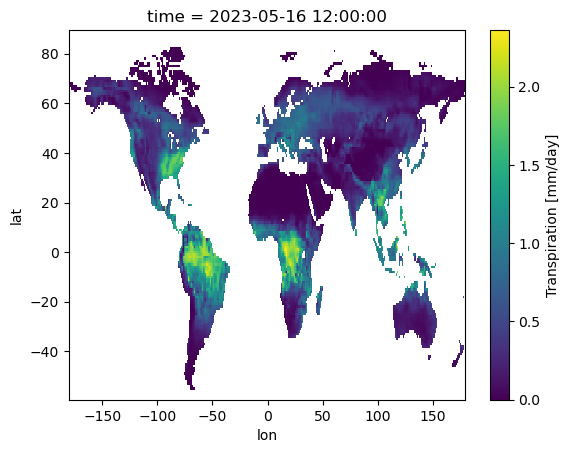

In [6]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=100).plot()

### 2. Check and set negative values to 0

In [17]:
check_positive_negative_values(ds_dict[experiments[0]])

Checking positive and negative values for model: CAS-ESM2-0
- tran: 0
+ tran: 27285284
- pr: 0
+ pr: 29893744
- mrro: 1547212
+ mrro: 24608766


Checking positive and negative values for model: CMCC-ESM2
- tran: 0
+ tran: 26117258
- pr: 220
+ pr: 29877357
- mrro: 1556669
+ mrro: 26715751


Checking positive and negative values for model: FGOALS-g3
- tran: 0
+ tran: 26658669
- pr: 0
+ pr: 29894040
- mrro: 2664562
+ mrro: 26488958


Checking positive and negative values for model: GISS-E2-1-H
- tran: 0
+ tran: 25830943
- pr: 0
+ pr: 29890949
- mrro: 0
+ mrro: 27481582


Checking positive and negative values for model: CanESM5-CanOE
- tran: 0
+ tran: 21798307
- pr: 0
+ pr: 29870244
- mrro: 0
+ mrro: 26242558


Checking positive and negative values for model: IPSL-CM5A2-INCA
- tran: 496
+ tran: 23079278
- pr: 0
+ pr: 28262708
- mrro: 0
+ mrro: 10746915


Checking positive and negative values for model: KACE-1-0-G
- tran: 0
+ tran: 23732581
- pr: 0
+ pr: 29859227
- mrro: 0
+ mrro: 22457315


In [33]:
# Correct the sign for a variable in the specific model if needed
#updated_ds_dict = {}
#updated_ds_dict = correct_variable_sign(ds_dict[experiments[0]], 'CAMS-CSM1-0', 'evspsbl')

In [6]:
updated_ds_dict = {}
updated_ds_dict = set_negative_values_to_zero(ds_dict[experiments[0]])

Processing model: CAS-ESM2-0
Variable 'tran' has no negative values in model 'CAS-ESM2-0'.
Variable 'pr' has no negative values in model 'CAS-ESM2-0'.
Variable 'mrro' has 1547212 negative values in model 'CAS-ESM2-0'. Setting them to zero.
Variable 'mrro' now has 0 negative values in model 'CAS-ESM2-0' after setting to zero.


Processing model: CMCC-ESM2
Variable 'tran' has no negative values in model 'CMCC-ESM2'.
Variable 'pr' has 220 negative values in model 'CMCC-ESM2'. Setting them to zero.
Variable 'pr' now has 0 negative values in model 'CMCC-ESM2' after setting to zero.
Variable 'mrro' has 1556669 negative values in model 'CMCC-ESM2'. Setting them to zero.
Variable 'mrro' now has 0 negative values in model 'CMCC-ESM2' after setting to zero.


Processing model: FGOALS-g3
Variable 'tran' has no negative values in model 'FGOALS-g3'.
Variable 'pr' has no negative values in model 'FGOALS-g3'.
Variable 'mrro' has 2664562 negative values in model 'FGOALS-g3'. Setting them to zero.
Vari

['CAS-ESM2-0', 'CMCC-ESM2', 'FGOALS-g3', 'GISS-E2-1-H', 'CanESM5-CanOE', 'IPSL-CM5A2-INCA', 'KACE-1-0-G', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3-Veg']


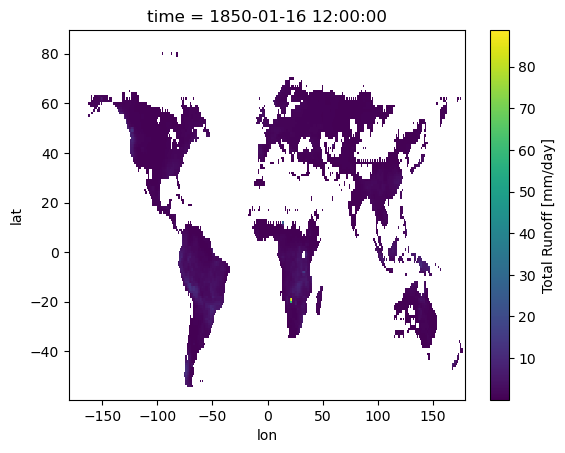

In [7]:
# ========= Have a look into the dictionary =======
print(list(updated_ds_dict.keys()))
updated_ds_dict[models[6]][variables[2]].isel(time=0).plot()

### 3. Save and replace netcdf files

In [8]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/


In [9]:
sd.save_files(updated_ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/pr/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/pr/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/mrro/CAS-ESM2-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/mrro/CAS-ESM2-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/CMCC-ESM2.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tran/CMCC-ESM2.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/pr/CMCC-ESM2.nc removed
File saved 